# Calculate phase dependent modulation of AP generation in response to spatially diffuse or concentrated poisson excitation and rhythmic inhibition

The simulations had either: 
1. Rhythmic inhibition at the soma (64 Hz) or dendrites (16 Hz) 
2. Diffuse or concentrated synaptic excitation at and dendrites

Here we calculate the cross-correlation between action potentials and input on spatially diffuse or concentrated synapses. These are stratified by:
1. Phase (peak or trough) of the inhibitory rhythm
2. Frequency of rhythm

The output of this script are...


In [1]:
import sys
import os
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.cc_presyn_phdep_files import cc_presyn_phdep_files
from src.load_spike_h5 import load_spike_h5
from src.load_spike_aux_h5 import load_spike_aux_h5
from src.cc_ptpt import cc_ptpt

### 1.1 Simulation constants and analysis windows

In [2]:
samps_per_ms = 10 # samples per millisecond
fs = 10000 # sampling frequency
sim_win = [0, 2000000] # beginning and start points of simulation in samples
cc_bin = samps_per_ms * 1 # bin size for cross-correlation in samples
cc_win_16 = [-62, 62] # number of lags for cross-correlation at 16 Hz inhibition
cc_win_64 = [-62, 62] # number of lags for cross-correlation at 64 Hz inhibition
cc_win_poiss = [-62, 62] # number of lags for cross-correlation with poisson inhibition

### 1.2 List files to be processed

In [3]:
# locate simulation files
dir_list = [{'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_conc_apical',
             'InhibType': '16', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_conc_basal',
             'InhibType': '16', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_diff',
                'InhibType': '16', 'ExcType': 'diff', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_lessdiffuse_apical',
                'InhibType': '16', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_conc_apical',
                'InhibType': '64', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_conc_basal',
                'InhibType': '64', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_diff',
                'InhibType': '64', 'ExcType': 'diff', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_lessdiffuse_apical',
                'InhibType': '64', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_conc_apical',
                'InhibType': 'poiss', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_conc_basal',
                'InhibType': 'poiss', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_diff',
                'InhibType': 'poiss', 'ExcType': 'diff', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_lessdiffuse_apical',
                'InhibType': 'poiss', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'}]

sim_df = pd.DataFrame(dir_list)
sim_df

,RootDir,InhibType,ExcType,ExcLoc
0,Z:\DendOscSub\output_clust_16Hz_conc_apical,16,conc,apical
1,Z:\DendOscSub\output_clust_16Hz_conc_basal,16,conc,basal
2,Z:\DendOscSub\output_clust_16Hz_diff,16,diff,apical
3,Z:\DendOscSub\output_clust_16Hz_lessdiffuse_ap...,16,lessdiffuse,apical
4,Z:\DendOscSub\output_clust_64Hz_conc_apical,64,conc,apical
5,Z:\DendOscSub\output_clust_64Hz_conc_basal,64,conc,basal
6,Z:\DendOscSub\output_clust_64Hz_diff,64,diff,apical
7,Z:\DendOscSub\output_clust_64Hz_lessdiffuse_ap...,64,lessdiffuse,apical
8,Z:\DendOscSub\output_clust_poiss_conc_apical,poiss,conc,apical
9,Z:\DendOscSub\output_clust_poiss_conc_basal,poiss,conc,basal


## 2.0 Phase startified cross-correlation between presynaptic spikes and action potentials

### 2.1 Generate phase series for each experiment

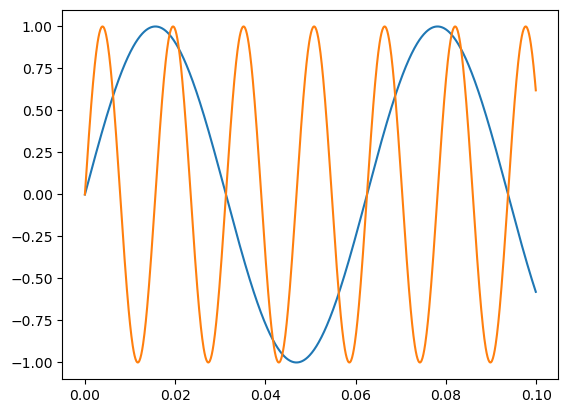

In [4]:
# generate phase time series for inhibitory afferents
t_ser = np.arange(sim_win[0], sim_win[1], 1) / fs # seconds
sin_16_ser = np.sin(t_ser*16*2*np.pi)
sin_64_ser = np.sin(t_ser*64*2*np.pi)

fig, ax = plt.subplots()
ax.plot(t_ser[0:1000],sin_16_ser[0:1000])
ax.plot(t_ser[0:1000],sin_64_ser[0:1000])
plt.show()

### 2.2 Calculate cross-correlations

In [5]:
def cc_func(sim_dir, inhib_type):
    # create full file path for presynaptic spike times and AP times, make OS independent
    presyn_file = os.path.join(sim_dir, 'exc_stim_aux_spikes2.h5')
    ap_file = os.path.join(sim_dir, 'spikes.h5')

    # calculate cross-correlation
    if inhib_type == '16':
        cc = cc_presyn_phdep_files(presyn_file, ap_file, sin_16_ser, cc_bin, cc_win_16)
    elif inhib_type == '64':
        cc = cc_presyn_phdep_files(presyn_file, ap_file, sin_64_ser, cc_bin, cc_win_64)
    elif inhib_type == 'poiss':
        spk_pts = load_spike_h5(ap_file)
        pre_pts = load_spike_aux_h5(presyn_file)
        cc = {'poiss': cc_ptpt(spk_pts, pre_pts, cc_bin, cc_win_poiss)}
    return cc

# calculate cross-correlation for each simulation
sim_df = sim_df.assign(AllCC = sim_df.apply(lambda x: cc_func(x['RootDir'], x['InhibType']), axis=1))

In [6]:
# breakout CC dictionaries
sim_df = sim_df.join(pd.DataFrame(sim_df['AllCC'].tolist()))
sim_df = pd.melt(sim_df, id_vars=['RootDir', 'InhibType', 'ExcType', 'ExcLoc'],
                 value_vars=['t', 'p', 'poiss'], var_name='InhibPhase', value_name='CC')
sim_df = sim_df.dropna()
sim_df = sim_df.reset_index(drop=True)
sim_df = sim_df.join(pd.DataFrame(sim_df['CC'].tolist()))
sim_df.drop('CC', axis=1)

,RootDir,InhibType,ExcType,ExcLoc,InhibPhase,values,lags,ref_norm,values_corr
0,Z:\DendOscSub\output_clust_16Hz_conc_apical,16,conc,apical,t,"[181.0, 167.0, 208.0, 164.0, 216.0, 195.0, 171...","[-62, -61, -60, -59, -58, -57, -56, -55, -54, ...",0.000030,"[(0.007410918716896127-3.60076833642982e-18j),..."
1,Z:\DendOscSub\output_clust_16Hz_conc_basal,16,conc,basal,t,"[207.0, 179.0, 224.0, 202.0, 192.0, 178.0, 177...","[-62, -61, -60, -59, -58, -57, -56, -55, -54, ...",0.000030,"[(0.00808298447560201-3.117039498041382e-18j),..."
2,Z:\DendOscSub\output_clust_16Hz_diff,16,diff,apical,t,"[139.0, 171.0, 151.0, 132.0, 191.0, 147.0, 160...","[-62, -61, -60, -59, -58, -57, -56, -55, -54, ...",0.000030,[(0.0018507060336129383-3.915170502104192e-18j...
3,Z:\DendOscSub\output_clust_16Hz_lessdiffuse_ap...,16,lessdiffuse,apical,t,"[196.0, 219.0, 234.0, 280.0, 210.0, 210.0, 236...","[-62, -61, -60, -59, -58, -57, -56, -55, -54, ...",0.000030,[(0.0008247491436944205-1.0833968532211371e-18...
4,Z:\DendOscSub\output_clust_64Hz_conc_apical,64,conc,apical,t,"[235.0, 272.0, 298.0, 309.0, 295.0, 261.0, 210...","[-62, -61, -60, -59, -58, -57, -56, -55, -54, ...",0.000030,[(0.007544125395027329+5.103379628086357e-19j)...
5,Z:\DendOscSub\output_clust_64Hz_conc_basal,64,conc,basal,t,"[131.0, 164.0, 202.0, 220.0, 209.0, 205.0, 172...","[-62, -61, -60, -59, -58, -57, -56, -55, -54, ...",0.000030,[(0.002097328338058384+6.487571577934263e-19j)...
6,Z:\DendOscSub\output_clust_64Hz_diff,64,diff,apical,t,"[159.0, 184.0, 209.0, 210.0, 235.0, 208.0, 203...","[-62, -61, -60, -59, -58, -57, -56, -55, -54, ...",0.000030,[(0.006486582404298306-1.6658872815911694e-19j...
7,Z:\DendOscSub\output_clust_64Hz_lessdiffuse_ap...,64,lessdiffuse,apical,t,"[180.0, 202.0, 197.0, 281.0, 289.0, 278.0, 220...","[-62, -61, -60, -59, -58, -57, -56, -55, -54, ...",0.000030,[(0.004804289575316449-5.023549717215632e-19j)...
8,Z:\DendOscSub\output_clust_16Hz_conc_apical,16,conc,apical,p,"[72.0, 39.0, 29.0, 29.0, 23.0, 24.0, 26.0, 39....","[-62, -61, -60, -59, -58, -57, -56, -55, -54, ...",0.000030,[(0.0029132576785693217+3.4538423962728657e-18...
9,Z:\DendOscSub\output_clust_16Hz_conc_basal,16,conc,basal,p,"[64.0, 76.0, 58.0, 43.0, 44.0, 51.0, 37.0, 35....","[-62, -61, -60, -59, -58, -57, -56, -55, -54, ...",0.000030,[(-0.00180008702501024+3.7951777248064914e-18j...


In [56]:
# group by excitatory input type
exc_df = sim_df.groupby(['ExcType', 'ExcLoc'])

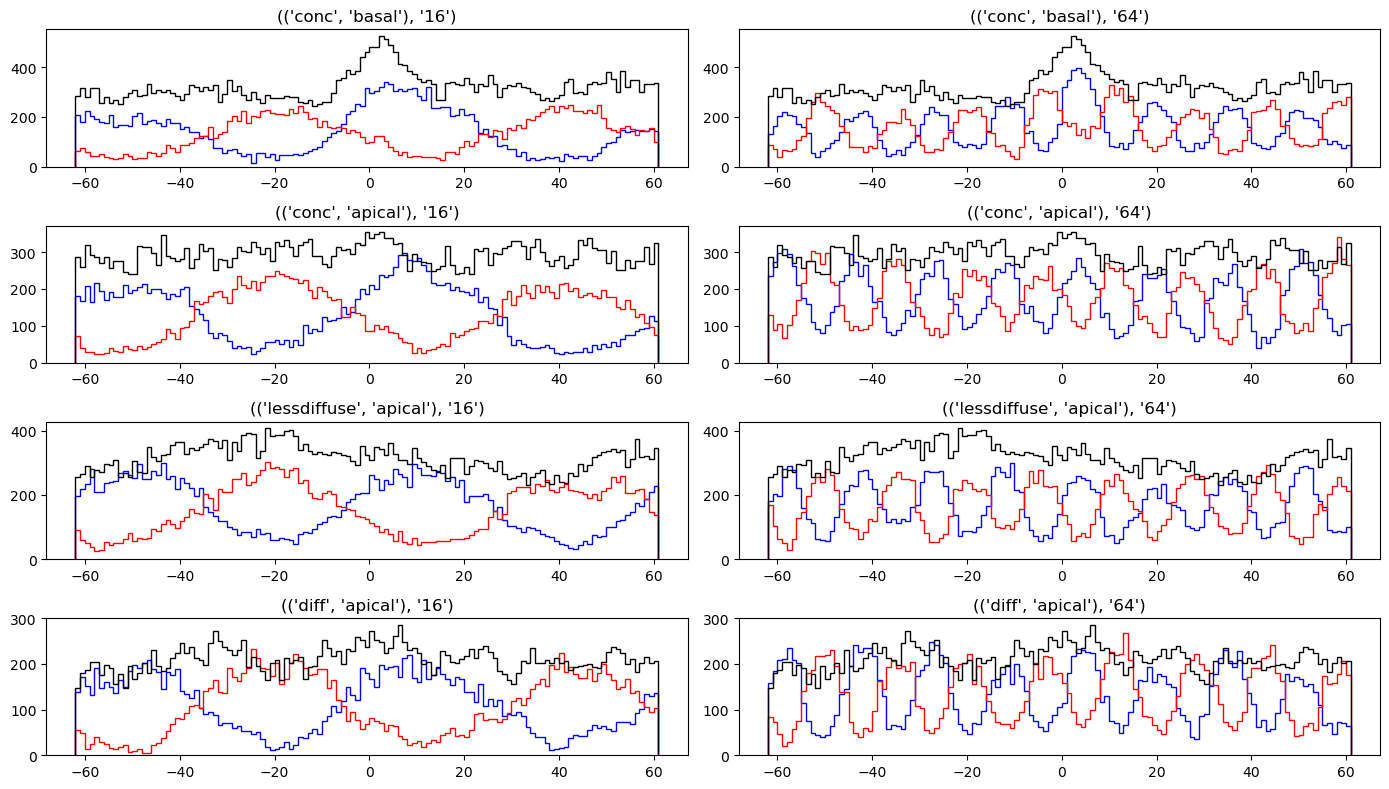

In [61]:
def plot_cc(sim_row, ax, **kwargs):
    ax.stairs(sim_row['values'].iloc[0][0:-1], sim_row['lags'].iloc[0],  **kwargs)

def plot_exp(sim_set, exp_name, exp_freq, ax):
    plot_cc(sim_set.loc[(sim_set['InhibPhase']=='t') & (sim_set['InhibType']==exp_freq)],ax, color='b')
    plot_cc(sim_set.loc[(sim_set['InhibPhase']=='p') & (sim_set['InhibType']==exp_freq)],ax, color='r')
    plot_cc(sim_set[sim_set['InhibPhase']=='poiss'],ax, color='k')
    ax.set_title((exp_name, exp_freq))

fig,ax = plt.subplots(4,2)
plot_exp(exc_df.get_group(('conc', 'basal')), ('conc', 'basal'), '16',ax[0,0])
plot_exp(exc_df.get_group(('conc', 'basal')), ('conc', 'basal'), '64',ax[0,1])
plot_exp(exc_df.get_group(('conc', 'apical')), ('conc', 'apical'), '16',ax[1,0])
plot_exp(exc_df.get_group(('conc', 'apical')), ('conc', 'apical'), '64',ax[1,1])
plot_exp(exc_df.get_group(('lessdiffuse', 'apical')), ('lessdiffuse', 'apical'), '16',ax[2,0])
plot_exp(exc_df.get_group(('lessdiffuse', 'apical')), ('lessdiffuse', 'apical'), '64',ax[2,1])
plot_exp(exc_df.get_group(('diff', 'apical')), ('diff', 'apical'), '16',ax[3,0])
plot_exp(exc_df.get_group(('diff', 'apical')), ('diff', 'apical'), '64',ax[3,1])
fig.set_size_inches(14, 8)
fig.tight_layout()